# Explanaible AI - Permutation Importance - sklearn
Sklean offer a a method to calculate **permutation importance**. 

**It shoud be similar to the Permutation Importance offer by eli5** (remember eli5 return and error importing the package, probably because it is too old) (last update 11 may 2022)

#### Link sklearn:
- Documentation code: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#rd9e56ef97513-bre
- User Guide Permutation Importance: https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

#### Link eli5:
- https://pypi.org/project/eli5/

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# shap
import shap

# models
from sklearn.linear_model import LinearRegression # lr
from sklearn.linear_model import Ridge # ridge
from sklearn.linear_model import Lasso # lasso
from sklearn.tree import DecisionTreeRegressor # tree
from sklearn.ensemble import GradientBoostingRegressor #gb
from sklearn.ensemble import RandomForestRegressor #rf
from xgboost import XGBRegressor # xgb
from  sklearn.neural_network import MLPRegressor # mlp

### Explication
Índice:
- 1) Qué es permutation Importance
- 2) Cómo se calcula
- 3) Entendimiento de los valores obtenidos. Alta/Baja importancia
- 4) Calcular Permutation Importance es transversal independiente el modelo
- 5) Otro uso, analizar performance de un modelo agregando variables random (ruido)
- 6) Obtener primero un buen modelo. Luego calcular Importancias

1. La importancia de la característica de permutación es una técnica de inspección de modelos que mide la **contribución de cada característica al rendimiento de un modelo** ajustado en un conjunto de datos tabulares determinado. 

2. Esta técnica es particularmente útil para estimadores no lineales u opacos e **implica mezclar aleatoriamente los valores de una sola característica y observar la degradación resultante de la puntuación del modelo. Al romper la relación entre la característica y el objetivo, determinamos en qué medida el modelo depende de esa característica en particular**
3. **Si la perturbación de una feature rompe la correlación entre la feature y el target, el rendimiento del modelo disminuye (se obtiene peores métricas).** Por el contrario, si la perturbación de una feaure no degrada significativamente el rendimiento del modelo, es una feature no predictiva

4. **Una ventaja clave de la importancia de la característica de permutación es que es independiente del modelo, es decir, se puede aplicar a cualquier estimador ajustado. Además, se puede calcular varias veces con diferentes permutaciones de la característica, lo que proporciona además una medida de la varianza en las importancias estimadas de las características para el modelo entrenado específico.**

5. También se puede utilizar para **analizar cómo funciona un modelo agregando variables random (ruido)**. La idea es que el modelo no reconozca como features más importantes las feautures que son ruido porque significaría que el modelo es muy malo, o muy complejo que es capaz de predecir sobreajustando el ruido

6. **Advertencia importancia de features de un mal modelo**. Las características que se consideran de baja importancia para un mal modelo (puntuación de validación cruzada baja) podrían ser muy importantes para un buen modelo . Por lo tanto, siempre es importante evaluar el poder predictivo de un modelo utilizando un conjunto reservado (o mejor con validación cruzada) antes de calcular las importancias. La importancia de la permutación no refleja el valor predictivo intrínseco de una característica en sí misma, sino la importancia de esta característica para un modelo en particularo.

#### TODO: the sum of values of permutation importance are the metric?
Because to calculate the value of permutation importance is generated changing the values of the feature and calculate the metric. An doing this it is possible to see how the performance of the model get worse.

**According the documentation, each value returned in permutation importance is the evaluation of the metric with the corrupted data**

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LinearRegression # lr
from sklearn.linear_model import Ridge # ridge
from sklearn.linear_model import Lasso # lasso
from sklearn.tree import DecisionTreeRegressor # tree
from sklearn.ensemble import GradientBoostingRegressor #gb
from sklearn.ensemble import RandomForestRegressor #rf
from xgboost import XGBRegressor # xgb
from  sklearn.neural_network import MLPRegressor # mlp

# permutation importance
from sklearn.inspection import permutation_importance

### 1. Load data

In [3]:
##### load data
data_X, data_y = fetch_california_housing(return_X_y=True, as_frame=True)

##### joinn and rename dataset
data = data_X.copy()
data['Price'] = data_y

##### dropduplicates - some kind of plots in plotly return error with duplicated values
data = data.drop_duplicates()

##### delete outliers
percentil_lower = data.quantile(0.01)
percentil_upper = data.quantile(0.99)

data_raw = data[(data >= percentil_lower) & (data <= percentil_upper)]
data_raw.dropna(inplace = True)


##### split into train/test
target = 'Price'
list_features = list(set(data_raw.columns) - set([target]))

X_train, X_test, y_train, y_test = train_test_split(data_raw[list_features], 
                                                    data_raw[[target]], 
                                                    test_size = 0.2, 
                                                    random_state=42
                                                   )

In [4]:
list_features

['Longitude',
 'Population',
 'Latitude',
 'AveBedrms',
 'HouseAge',
 'MedInc',
 'AveRooms',
 'AveOccup']

In [5]:
X_train.head()

,Longitude,Population,Latitude,AveBedrms,HouseAge,MedInc,AveRooms,AveOccup
5712,-118.24,926.0,34.22,1.094340,34.0,4.1523,4.641509,2.495957
15731,-122.44,1588.0,37.78,1.063750,52.0,3.3882,3.771250,1.985000
2894,-118.99,743.0,35.37,0.990991,38.0,1.7292,4.135135,3.346847
3333,-122.62,249.0,38.92,1.055046,13.0,1.8417,4.770642,2.284404
8410,-118.35,2649.0,33.93,1.026738,33.0,2.3375,3.636364,4.721925


### 2. Train models

#### 2.1 Linear regression

In [6]:
# train lr
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [7]:
# r2 score
r2_lr_train = lr.score(X_train, y_train)
r2_lr_test = lr.score(X_test, y_test)

print('r2_train: ', r2_lr_train)
print('r2_test: ', r2_lr_test)

r2_train:  0.6811276939092024
r2_test:  0.6813140626891637


#### 2.2 Random Forest

In [8]:
# train rf simple
param_n_trees = 3
rf_simple = RandomForestRegressor(n_estimators = param_n_trees,
                                  random_state = 42,
                                 min_samples_split = 0.2,
                                    min_samples_leaf = 0.1)
                                   #max_depth = 2)
rf_simple.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=0.1, min_samples_split=0.2,
                      n_estimators=3, random_state=42)

In [9]:
# r2 score
r2_rf_simple_train = rf_simple.score(X_train, y_train)
r2_rf_simple_test = rf_simple.score(X_test, y_test)

print('r2_train: ', r2_rf_simple_train)
print('r2_test: ', r2_rf_simple_test)

r2_train:  0.4568652486893102
r2_test:  0.434027414718105


#### 2.3 Random Forest Default

In [10]:
# train rf default hiperparameters
rf_default = RandomForestRegressor(random_state = 42)
rf_default.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
# r2 score
r2_rf_default_train = rf_default.score(X_train, y_train)
r2_rf_default_test = rf_default.score(X_test, y_test)

print('r2_train: ', r2_rf_default_train)
print('r2_test: ', r2_rf_default_test)

r2_train:  0.974266916282628
r2_test:  0.8098872210813666


### 3. Permutation Importance

#### 3.1 Calculation Permutation Importance

In [12]:
# list features
list_features

['Longitude',
 'Population',
 'Latitude',
 'AveBedrms',
 'HouseAge',
 'MedInc',
 'AveRooms',
 'AveOccup']

In [13]:
# calculate permutation importances
results = permutation_importance(estimator = lr, 
                                 X = X_train, 
                                 y = y_train, 
                                 n_repeats = 30,
                                 random_state = 42
                                )

In [14]:
results

{'importances_mean': array([0.96347181, 0.00383761, 1.14021907, 0.02961554, 0.0453167 ,
        1.10182401, 0.03997304, 0.11650087]),
 'importances_std': array([0.01030205, 0.0003979 , 0.01085019, 0.00106535, 0.00159285,
        0.01103696, 0.00112002, 0.00256492]),
 'importances': array([[0.96215384, 0.97155904, 0.97953786, 0.95599389, 0.94786426,
         0.96201092, 0.95635709, 0.96847684, 0.95371486, 0.97011378,
         0.95352995, 0.94976827, 0.96523152, 0.94603355, 0.97113484,
         0.9827264 , 0.95724219, 0.96254196, 0.96226893, 0.98033092,
         0.9633458 , 0.96605785, 0.95609589, 0.95233887, 0.95925484,
         0.98391823, 0.97421544, 0.97577928, 0.96108315, 0.95347418],
        [0.00392532, 0.00421105, 0.00377724, 0.00428794, 0.00382861,
         0.0040744 , 0.00438026, 0.00318544, 0.00387613, 0.00391703,
         0.00345337, 0.00428024, 0.00371359, 0.0042801 , 0.00350167,
         0.00441054, 0.00344649, 0.00345939, 0.00392944, 0.00323539,
         0.00324408, 0.0044

In [15]:
# importances mean
results['importances_mean']

array([0.96347181, 0.00383761, 1.14021907, 0.02961554, 0.0453167 ,
       1.10182401, 0.03997304, 0.11650087])

In [16]:
# importances std
results['importances_std']

array([0.01030205, 0.0003979 , 0.01085019, 0.00106535, 0.00159285,
       0.01103696, 0.00112002, 0.00256492])

In [17]:
# all values of importances. dimensions (features, repeats)
results['importances']

array([[0.96215384, 0.97155904, 0.97953786, 0.95599389, 0.94786426,
        0.96201092, 0.95635709, 0.96847684, 0.95371486, 0.97011378,
        0.95352995, 0.94976827, 0.96523152, 0.94603355, 0.97113484,
        0.9827264 , 0.95724219, 0.96254196, 0.96226893, 0.98033092,
        0.9633458 , 0.96605785, 0.95609589, 0.95233887, 0.95925484,
        0.98391823, 0.97421544, 0.97577928, 0.96108315, 0.95347418],
       [0.00392532, 0.00421105, 0.00377724, 0.00428794, 0.00382861,
        0.0040744 , 0.00438026, 0.00318544, 0.00387613, 0.00391703,
        0.00345337, 0.00428024, 0.00371359, 0.0042801 , 0.00350167,
        0.00441054, 0.00344649, 0.00345939, 0.00392944, 0.00323539,
        0.00324408, 0.00447463, 0.00356485, 0.00420226, 0.0039697 ,
        0.00356304, 0.00302993, 0.00369071, 0.00391889, 0.00429643],
       [1.16281693, 1.12200884, 1.1356725 , 1.15401802, 1.13910078,
        1.1415226 , 1.14912426, 1.12745714, 1.12971652, 1.15659505,
        1.13964825, 1.15789134, 1.13449752, 1.

In [18]:
results['importances'].shape

(8, 30)

In [19]:
results['importances'].mean(axis = 1) # example calculation importances mean

array([0.96347181, 0.00383761, 1.14021907, 0.02961554, 0.0453167 ,
       1.10182401, 0.03997304, 0.11650087])

In [20]:
results['importances'].mean() # mean value of permutation importance

0.4300948299122681

#### 3.2 Box Plot permutation Importance each feature

In [21]:
list_features

['Longitude',
 'Population',
 'Latitude',
 'AveBedrms',
 'HouseAge',
 'MedInc',
 'AveRooms',
 'AveOccup']

In [22]:
# get index permutation importances sorted
sorted_idx = results.importances_mean.argsort()

In [23]:
# sort list features acording sorted_idx
from operator import itemgetter
sorted_features = itemgetter(*sorted_idx)(list_features)
sorted_features

('Population',
 'AveBedrms',
 'AveRooms',
 'HouseAge',
 'AveOccup',
 'Longitude',
 'MedInc',
 'Latitude')

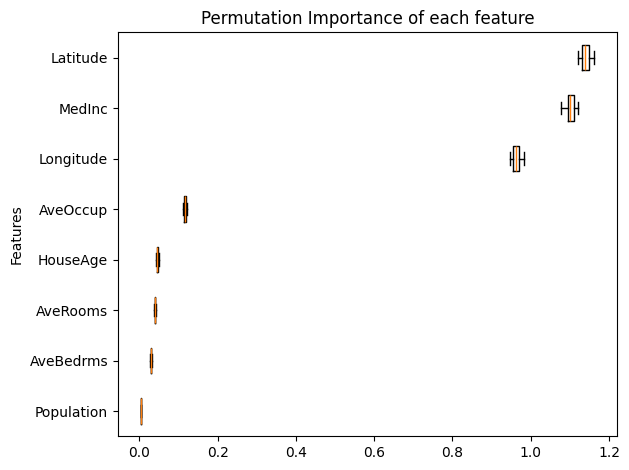

In [24]:
# plot
fig, ax = plt.subplots()

ax.boxplot(
    results.importances[sorted_idx].T, vert = False, labels = sorted_features
)

ax.set_title("Permutation Importance of each feature")
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

#### 3.3 Barplot permutation importance

In [25]:
# define a series with importances (mean) of each feature
df_importances = pd.Series(results.importances_mean, index = list_features)
df_importances

Longitude     0.963472
Population    0.003838
Latitude      1.140219
AveBedrms     0.029616
HouseAge      0.045317
MedInc        1.101824
AveRooms      0.039973
AveOccup      0.116501
dtype: float64

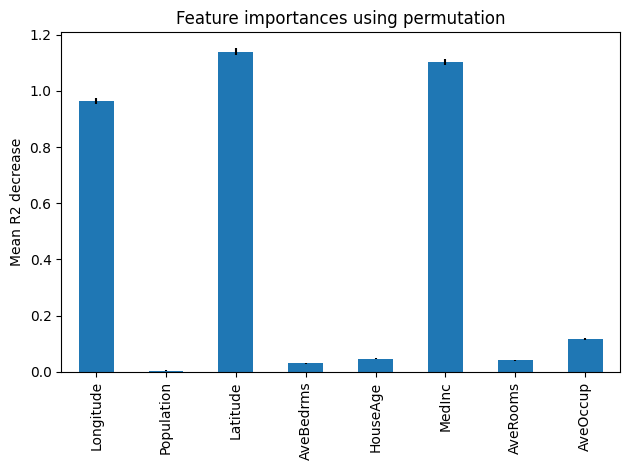

In [26]:
# plot
fig, ax = plt.subplots()
df_importances.plot.bar(yerr = results.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean R2 decrease")
fig.tight_layout()
plt.show()

#### TODO: review this

#### why latitude has higher values than R2 of permutation importance
GPT response:

Si el valor de la importancia de la permutación (permutation importance) es mayor que el coeficiente de determinación (R^2) del modelo, generalmente se interpreta como que esa característica no es útil para predecir la variable objetivo.

El coeficiente de determinación (R^2) mide la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes en el modelo. Un valor de R^2 cercano a 1 indica que el modelo explica una gran parte de la variabilidad de la variable dependiente, mientras que un valor cercano a 0 indica que el modelo no explica mucha variabilidad.

Por otro lado, la importancia de la permutación mide cuánto disminuye el rendimiento del modelo cuando se permuta una característica en comparación con cuando no se permuta. Si la importancia de la permutación es mayor que el R^2 del modelo, sugiere que permutar esa característica tiene un impacto más negativo en el rendimiento del modelo que simplemente eliminarla, lo que indica que la característica no está aportando información útil para predecir la variable objetivo.

En resumen, si la importancia de la permutación es mayor que el R^2 del modelo, se podría considerar eliminar esa característica del modelo, ya que no está ayudando a mejorar su capacidad predictiva.

#### 3.4 Interval Feature Importance

In [27]:
for i in results.importances_mean.argsort()[::-1]:
     
    if results.importances_mean[i] - 2 * results.importances_std[i] > 0:
        
        feature_importance_name = list_features[i]
        feature_importance_mean = results.importances_mean[i].round(4)
        feature_importance_std = results.importances_std[i].round(3)

        print(f'feature: {feature_importance_name} || {feature_importance_mean} +/- {feature_importance_std}')

feature: Latitude || 1.1402 +/- 0.011
feature: MedInc || 1.1018 +/- 0.011
feature: Longitude || 0.9635 +/- 0.01
feature: AveOccup || 0.1165 +/- 0.003
feature: HouseAge || 0.0453 +/- 0.002
feature: AveRooms || 0.04 +/- 0.001
feature: AveBedrms || 0.0296 +/- 0.001
feature: Population || 0.0038 +/- 0.0


#### 3.5 Evaluate model with random features

In [28]:
# list feature with noise
list_features_noise = list_features + ['noise']

In [29]:
# Create random feature
white_noise = np.random.normal(0, 1, X_train.shape[0])
X_train_noise = X_train.copy()
X_train_noise['noise'] = white_noise

In [30]:
# train lr
lr_noise = LinearRegression()
lr_noise.fit(X_train_noise, y_train)

# r2 score
r2_lr_noise_train = lr_noise.score(X_train_noise, y_train)
print('r2_train_noise: ', r2_lr_noise_train)
print('r2_train_NO_noise: ', r2_lr_train)

r2_train_noise:  0.6812330146508401
r2_train_NO_noise:  0.6811276939092024


In [31]:
# calculate permutation importances
results_noise = permutation_importance(estimator = lr_noise, 
                                 X = X_train_noise, 
                                 y = y_train, 
                                 n_repeats = 30,
                                 random_state = 42
                                )

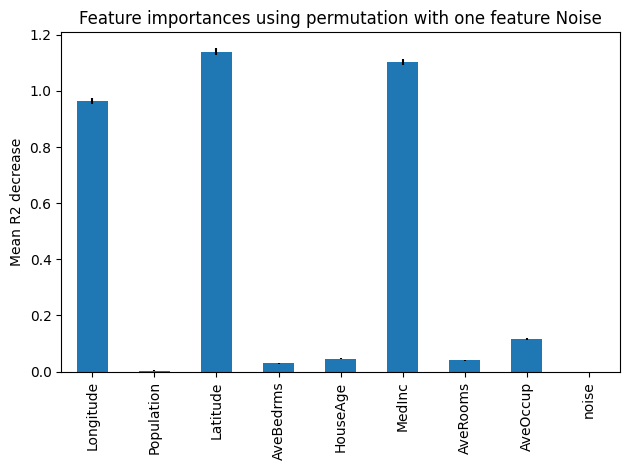

In [32]:
### barplot permutation importance

# define a series with importances (mean) of each feature
df_importances_noise = pd.Series(results_noise.importances_mean, index = list_features_noise)

fig, ax = plt.subplots()
df_importances_noise.plot.bar(yerr = results_noise.importances_std, ax=ax)

ax.set_title("Feature importances using permutation with one feature Noise")
ax.set_ylabel("Mean R2 decrease")
fig.tight_layout()
plt.show()

As you can see, the feature noise has 0 impact in the prediction

### 4. Permutation Importance vs Importance from emsemble models

#### 4.1 Feature Importance Random Forest
##### English 
The impurity-based feature importances.

**The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.**

Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative.


##### Spanish
La importancia de las características basadas en impurezas.

Cuanto más alto, más importante es la característica. La importancia de una característica se calcula como la reducción total (normalizada) del criterio aportado por esa característica. También se le conoce como la importancia de Gini.

Advertencia: las importancias de las características basadas en impurezas pueden ser engañosas para características de alta cardinalidad (muchos valores únicos). Ver sklearn.inspection.permutation_importancecomo alternativa.

In [33]:
# calculate feature importance rf
df_importances_rf = pd.Series(rf_default.feature_importances_, index = list_features)
df_importances_rf

Longitude     0.097027
Population    0.026818
Latitude      0.102888
AveBedrms     0.028518
HouseAge      0.056777
MedInc        0.502868
AveRooms      0.036811
AveOccup      0.148294
dtype: float64

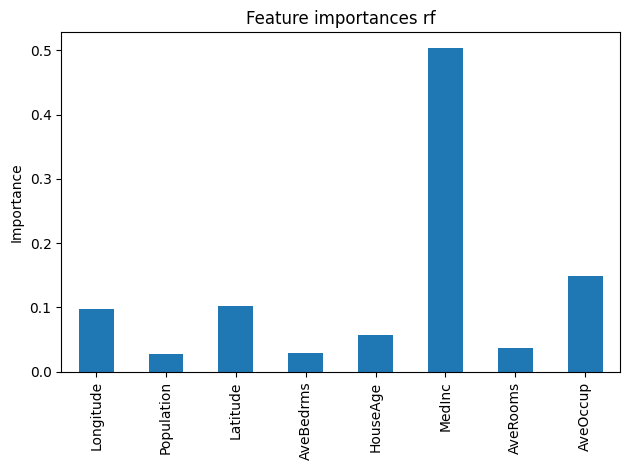

In [34]:
fig, ax = plt.subplots()
df_importances_rf.plot.bar()

ax.set_title("Feature importances rf")
ax.set_ylabel("Importance")
fig.tight_layout()
plt.show()

#### 4.2 Feature Importance Permutation

In [35]:
%%time
# calculate permutation importances
results_rf = permutation_importance(estimator = rf_default, 
                                 X = X_train, 
                                 y = y_train, 
                                 n_repeats = 30,
                                 random_state = 42
                                )

CPU times: total: 54 s
Wall time: 54 s


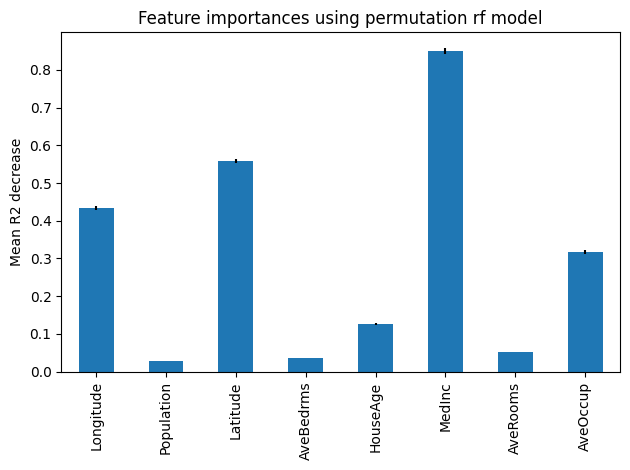

In [36]:
### barplot permutation importance

# define a series with importances (mean) of each feature
df_importances_rf = pd.Series(results_rf.importances_mean, index = list_features)

fig, ax = plt.subplots()
df_importances_rf.plot.bar(yerr = results_rf.importances_std, ax=ax)

ax.set_title("Feature importances using permutation rf model")
ax.set_ylabel("Mean R2 decrease")
fig.tight_layout()
plt.show()

#### 3.5 Feature Importance with random features

In [37]:
%%time
# train rf
rf_noise = RandomForestRegressor(random_state = 42)
rf_noise.fit(X_train_noise, y_train)

# r2 score
r2_rf_noise_train = rf_noise.score(X_train_noise, y_train)
print('r2_train_noise: ', r2_rf_noise_train)
print('r2_train_NO_noise: ', r2_rf_default_train)

r2_train_noise:  0.9738330435042135
r2_train_NO_noise:  0.974266916282628
CPU times: total: 30.2 s
Wall time: 30.2 s


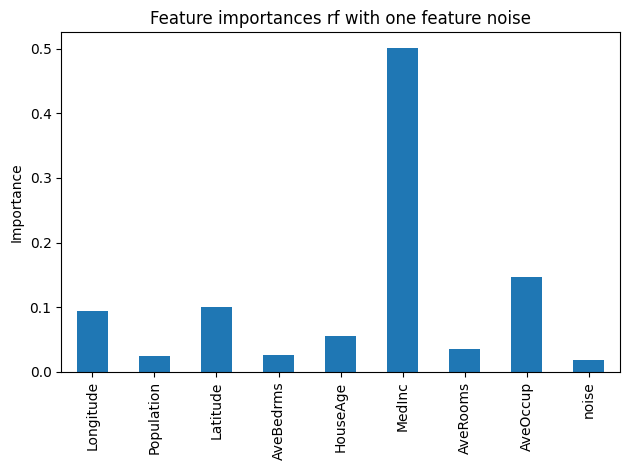

CPU times: total: 188 ms
Wall time: 181 ms


In [38]:
%%time
###### IMPORTANCE GINI RF

# calculate feature importance rf
df_importances_rf_noise = pd.Series(rf_noise.feature_importances_, index = list_features_noise)

fig, ax = plt.subplots()
df_importances_rf_noise.plot.bar()

ax.set_title("Feature importances rf with one feature noise")
ax.set_ylabel("Importance")
fig.tight_layout()
plt.show()

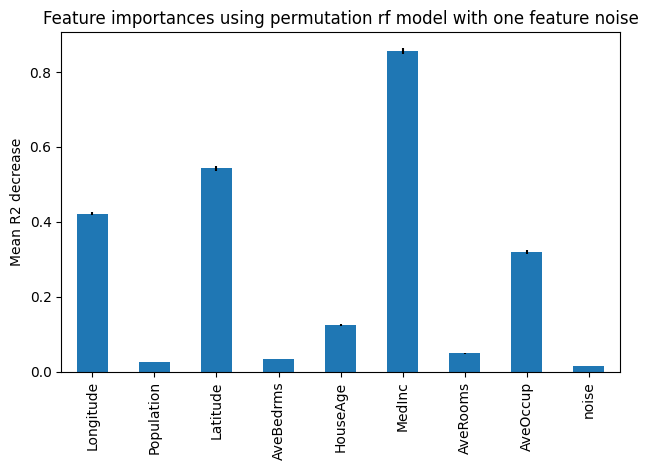

CPU times: total: 1min 1s
Wall time: 1min 1s


In [39]:
%%time
###### IMPORTANCE PERMUTATION

# calculate permutation importances
results_rf_noise = permutation_importance(estimator = rf_noise, 
                                 X = X_train_noise, 
                                 y = y_train, 
                                 n_repeats = 30,
                                 random_state = 42
                                )

### barplot permutation importance

# define a series with importances (mean) of each feature
df_importances_rf_noise = pd.Series(results_rf_noise.importances_mean, index = list_features_noise)

fig, ax = plt.subplots()
df_importances_rf_noise.plot.bar(yerr = results_rf_noise.importances_std, ax=ax)

ax.set_title("Feature importances using permutation rf model with one feature noise")
ax.set_ylabel("Mean R2 decrease")
fig.tight_layout()
plt.show()